In [88]:
# This must be at first cell
# This is a cell to hide code snippets from displaying

from IPython.display import HTML
hide_me = ''
HTML('''<script>
showcode=true; 
function code_toggle() {
  if (showcode) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  showcode = !showcode
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')

Notes:
    
https://www.markroepke.me/posts/2019/06/05/tips-for-slideshows-in-jupyter.html

In [89]:
# imports
import numpy as np
import scipy as sp
import h5py
import scipy.constants as const
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy.matlib
import time
from scipy.io import savemat, loadmat
from numba import njit
import random 

#from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages  # Save multiple plots to one pdf
from matplotlib.ticker import AutoMinorLocator  # For minor ticks on axes
from matplotlib.ticker import MaxNLocator  # Force integers on 2axes
from scipy.signal import argrelextrema  # To find maxima/minima
from pathlib import Path
import re
# import itertools
from itertools import cycle
import pandas as pd
import os

# A simple method for detecting chaos in nature

<center>Toker, D., Sommer, F. T., & D’Esposito, M. (2020). A simple method for detecting chaos in nature. Communications biology, 3(1), 1-13.

<center>
Journal Club, 28.10.2020

<center>
Nicholas Christiansen

## Overview

- What is chaos
- Mathematical description
    - Phase Space
    - The Lorenz System
    - Lyapunov Exponent
- Detecting chaos in nature
    - Method
    - Summary and discussion

0.5004089564341897


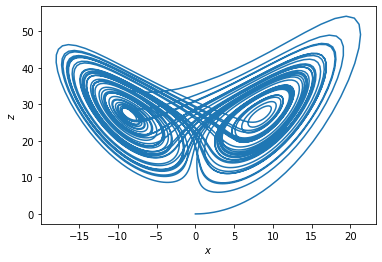

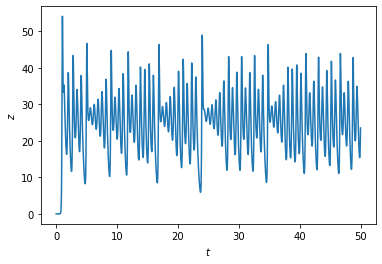

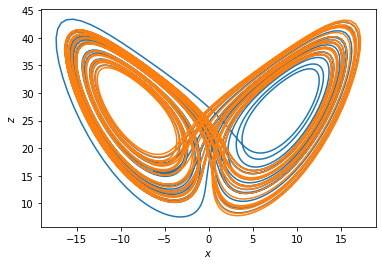

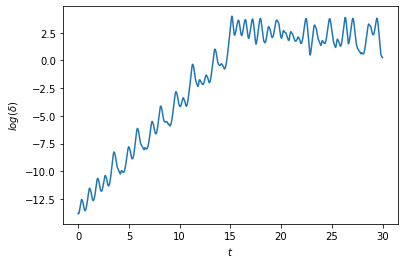

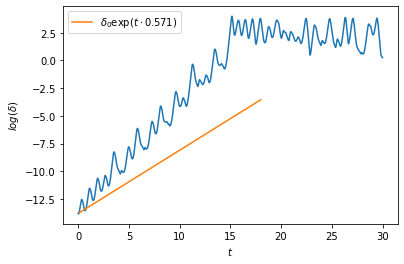

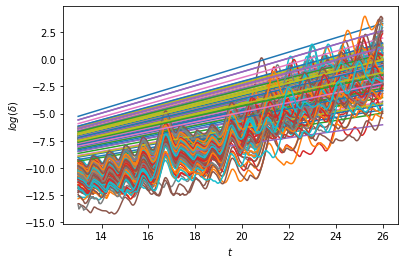

In [90]:

#Lorenz equations

@njit
def xDot(sigma,x,y):
    return sigma*(y-x)

@njit
def yDot(rho,x,y,z):
    return (x*(rho-z)-y)

@njit
def zDot(beta,x,y,z):
    return (x*y-beta*z)

#Timestep function for the 4th order Runge-Kutta routine
@njit
def timeStep(sigma,rho,beta,x,y,z,dt):
    k1x = xDot(sigma,x,y)
    k1y = yDot(rho,x,y,z)
    k1z = zDot(beta,x,y,z)

    k2x = xDot(sigma,x+0.5*dt*k1x,y)
    k2y = yDot(rho,x,y+0.5*dt*k1y,z)
    k2z = zDot(beta,x,y,z+0.5*dt*k1z)

    k3x = xDot(sigma,x+0.5*dt*k2x,y)
    k3y = yDot(rho,x,y+0.5*dt*k2y,z)
    k3z = zDot(beta,x,y,z+0.5*dt*k2z)

    k4x = xDot(sigma,x+dt*k3x,y)
    k4y = yDot(rho,x,y+dt*k3y,z)
    k4z = zDot(beta,x,y,z+dt*k3z)

    x+=dt/6*(k1x+2*k2x+2*k3x+k4x)
    y+=dt/6*(k1y+2*k2y+2*k3y+k4y)
    z+=dt/6*(k1z+2*k2z+2*k3z+k4z)

    return x,y,z

#time evolve the system
def timeEvolution(sigma,rho,beta,x0,y0,z0,t_0,t_end,dt):
    N = int((t_end-t_0)/dt)
    x = np.zeros(N+1)
    y = np.zeros(N+1)
    z = np.zeros(N+1)
    T = np.zeros(N+1)
    x[0],y[0],z[0] = x0, y0, z0
    for i in range(N):
        x[i+1],y[i+1],z[i+1] = timeStep(sigma,rho,beta,x[i],y[i],z[i],dt)
        T[i+1] = T[i]+dt
    return x,y,z,T

def RandSphere(x0):
    rand_ons = np.random.randn(3)
    rand_ons /= np.linalg.norm(rand_ons, axis=0)
    rand_ons = rand_ons*1e-6
    rand_ons[0] = rand_ons[0] + x0[0]
    rand_ons[1] = rand_ons[1] + x0[1]
    rand_ons[2] = rand_ons[2] + x0[2]
    return rand_ons

def RandTwo(x0):
    dx = np.random.uniform(-1, 1, size = 3)
    dx = 1e-6 * dx / np.sqrt(np.sum(dx**2))
    x1 = x0+dx
    return x1

#Code partly inspired by: https://github.com/nordam/TFY4305/blob/master/Notebooks/Problem_2_Lorenz.ipynb

@njit
def lorenz(x, sigma, rho, beta):
    xdot = sigma*(x[1] - x[0])
    ydot = x[0]*(rho - x[2]) - x[1]
    zdot = x[0]*x[1] - beta*x[2]
    return np.array([xdot, ydot, zdot])

@njit
def lorenz_f(x, t):
    sigma = 10.0
    rho   = 28.0
    beta  = 8/3
    return lorenz(x, sigma, rho, beta)


def delSig(x0, x1):
    return np.sqrt(np.sum((x0 - x1)**2, axis = 1))

def easyLorenz():
    x0 = 1e-2 * np.random.random(size = 3) + 0.1#np.random.randn(3)*1e-6
    x1= RandTwo(x0)
    T = 26
    t  = np.linspace(0, T, 5000)
    X0 = odeint(lorenz_f, x0, t)
    X1 = odeint(lorenz_f, x1, t)
    del_sig = delSig(X0, X1)
    (lam,), pcov = curve_fit(exp, t[int(np.floor(len(t)/2)):], del_sig[int(np.floor(len(t)/2)):])
    return lam, del_sig[int(np.floor(len(t)/2)):], t[int(np.floor(len(t)/2)):]

def exp(x, a):
    return 1e-6 * np.exp(a*x)

#rossler system

@njit
def rossler(x, a, b, c):
    xdot = -x[1] - x[2]
    ydot = x[0] + a*x[1]
    zdot = b + x[2]*(x[0] - c)
    return np.array([xdot, ydot, zdot])

@njit
def rossler_f(x, t):
    a = 0.2
    b = 0.2
    c = 5.7
    return rossler(x, a,b,c)

def easyRoss():
    x0 = 1e-2 * np.random.random(size = 3) + 0.1#np.random.randn(3)*1e-6
    x1= RandTwo(x0)
    dt = 0.001
    T = 230
    t  = np.linspace(0, T, T/dt)
    X0 = odeint(rossler_f, x0, t)
    X1 = odeint(rossler_f, x1, t)
    del_sig = delSig(X0, X1)
    (lam,), pcov = curve_fit(exp, t, del_sig, maxfev=1000)
    return lam, del_sig, t


#initial conditions
sigma = 10.
rho = 28.
beta = 8./3
dt = 0.01
x0 = 0.001
y0 = 0.001
z0 = 0.001
T = 50

# #solve the Lorenz equations until from time 0 to time T
x,y,z,T = timeEvolution(sigma,rho,beta,x0,y0,z0,0,T,dt)


#plot the solution to the Lorenz equations
fig_lor, axis_lor = plt.subplots(1,1)

axis_lor.plot(x,z)
axis_lor.set_xlabel('$x$')
axis_lor.set_ylabel('$z$')

fig_lor.savefig('fig_lor.png')

#2a:
fig_z_t, axis_z_t = plt.subplots(1,1)

axis_z_t.plot(T,z)
axis_z_t.set_xlabel('$t$')
axis_z_t.set_ylabel('$z$')

fig_z_t.savefig('fig_z_t.png')

# #solve the Lorenz equations until from time 0 to time T

sigma = 10.
rho = 28.
beta = 8./3
dt = 0.01
x0 = 0.001
y0 = 0.001
z0 = 0.001
T = 30

#x,y,z,T = timeEvolution(sigma,rho,beta,x0[0],x0[1],x0[2],0,T,dt)
#x0,y0,z0,T0 = timeEvolution(sigma,rho,beta,x0[0],x0[1],x0[2],0,T,dt)
x0,y0,z0,T = timeEvolution(sigma,rho,beta,x0,y0,z0,0,T,dt)
#x0 = 1e-2 * np.random.random(size = 3) + 0.1#np.random.randn(3)*1e-6
x1 = [x0[-1],y0[-1],z0[-1]]
x2= RandTwo(x1)
T = 30
t  = np.linspace(0, T, 3000)
X0 = odeint(lorenz_f, x1, t)
X1 = odeint(lorenz_f, x2, t)

#plot the solution to the Lorenz equations
fig_lor_rand1, axis_lor_rand1 = plt.subplots(1,1)

axis_lor_rand1.plot(X0[:,0],X0[:,2])
axis_lor_rand1.plot(X1[:,0],X1[:,2])
axis_lor_rand1.set_xlabel('$x$')
axis_lor_rand1.set_ylabel('$z$')

fig_lor_rand1.savefig('fig_lor_rand_nor2.png')


del_sig = delSig(X0, X1)

fig_lor_sigma, axis_lor_sigma = plt.subplots(1,1)

axis_lor_sigma.plot(t, np.log(del_sig))

axis_lor_sigma.set_xlabel('$t$')
axis_lor_sigma.set_ylabel('$log( \delta)$')

fig_lor_sigma.savefig('fig_lor_sigma.png')


fig_lor_sigma3, axis_lor_sigma3 = plt.subplots(1,1)

axis_lor_sigma3.plot(t, np.log(del_sig))

axis_lor_sigma3.set_xlabel('$t$')
axis_lor_sigma3.set_ylabel('$log( \delta)$')

(a,), pcov = curve_fit(exp, t, del_sig)
axis_lor_sigma3.plot(t[10:1800], np.log(exp(t[10:1800], a)), label = '$\delta_0 \exp(t\cdot%.03f)$' % a)

axis_lor_sigma3.legend()
fig_lor_sigma3.savefig('fig_lor_sigm3a.png')


fig_easy_lor, axis_easy_lor = plt.subplots(1,1)

liapunov = 0
N = 100
for i in range(N):
    lam, del_sig, t = easyLorenz()
    axis_easy_lor.plot(t, np.log(exp(t, lam)))
    axis_easy_lor.plot(t, np.log(del_sig))
    liapunov+=lam

axis_easy_lor.set_xlabel('$t$')
axis_easy_lor.set_ylabel('$log( \delta)$')

fig_easy_lor.savefig('fig_easy2.pdf')

print(liapunov/N)
#


# What is chaos?



In [91]:
import math
from PIL import Image
imgx = 1000
imgy = 500
image = Image.new("RGB", (imgx, imgy))

xa = 2.9
xb = 4.0
maxit = 1000

for i in range(imgx):
    r = xa + (xb - xa) * float(i) / (imgx - 1)
    x = 0.5
    for j in range(maxit):
        x = r * x * (1 - x)
        if j > maxit / 2:
            image.putpixel((i, int(x * imgy)), (255, 255, 255))

image.save("Bifurcation.png", "PNG")
#plt.imshow(image)

### <center>Bifurcation diagram

$$ x = r \cdot x (1 - x)$$

<center>
    
<img src="Bifurcation.png">
</center>

### <center>Mandelbrot fractal


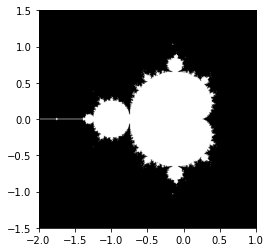

In [92]:
hide_me
#https://scipy-lectures.org/intro/numpy/auto_examples/plot_mandelbrot.html
from numpy import newaxis

def compute_mandelbrot(N_max, some_threshold, nx, ny):
    # A grid of c-values
    x = np.linspace(-2, 1, nx)
    y = np.linspace(-1.5, 1.5, ny)

    c = x[:,newaxis] + 1j*y[newaxis,:]

    # Mandelbrot iteration

    z = c

    # The code below overflows in many regions of the x-y grid, suppress
    # warnings temporarily
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        for j in range(N_max):
            z = z**2 + c
        mandelbrot_set = (abs(z) < some_threshold)

    return mandelbrot_set

mandelbrot_set = compute_mandelbrot(50, 50., 601, 401)


plt.imshow(mandelbrot_set.T, extent=[-2, 1, -1.5, 1.5])
plt.gray()
fig = plt.gcf()
fig.savefig('Mandelbrot.png')

In [93]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])
simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)
#$$ X_t = c + \epsilon_t + \sum^p_i{\rho_i X_{t-i}} + \sum^q_i{ \theta_i \epsilon_{t-i} } $$

# Different types of signals

Linear stochastic:

Non-Linear stochastic: 

Chaotic: 
<img src="fig_z_t.png">

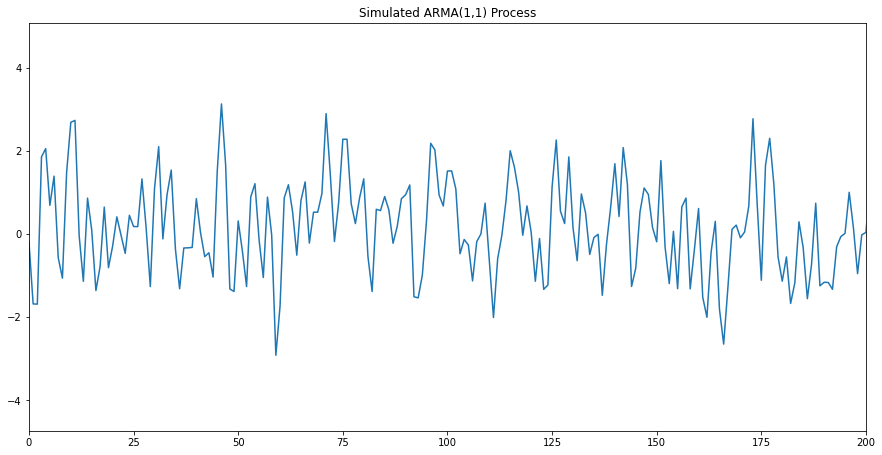

In [94]:
hide_me
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

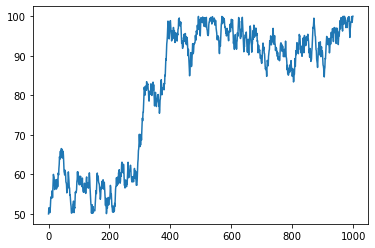

In [95]:
hide_me

def bounded_random_walk(length, lower_bound,  upper_bound, start, end, std):
    assert (lower_bound <= start and lower_bound <= end)
    assert (start <= upper_bound and end <= upper_bound)

    bounds = upper_bound - lower_bound

    rand = (std * (np.random.random(length) - 0.5)).cumsum()
    rand_trend = np.linspace(rand[0], rand[-1], length)
    rand_deltas = (rand - rand_trend)
    rand_deltas /= np.max([1, (rand_deltas.max()-rand_deltas.min())/bounds])

    trend_line = np.linspace(start, end, length)
    upper_bound_delta = upper_bound - trend_line
    lower_bound_delta = lower_bound - trend_line

    upper_slips_mask = (rand_deltas-upper_bound_delta) >= 0
    upper_deltas =  rand_deltas - upper_bound_delta
    rand_deltas[upper_slips_mask] = (upper_bound_delta - upper_deltas)[upper_slips_mask]

    lower_slips_mask = (lower_bound_delta-rand_deltas) >= 0
    lower_deltas =  lower_bound_delta - rand_deltas
    rand_deltas[lower_slips_mask] = (lower_bound_delta + lower_deltas)[lower_slips_mask]

    return trend_line + rand_deltas

randomData = bounded_random_walk(1000, lower_bound=50, upper_bound =100, start=50, end=100, std=10)

plt.plot(randomData) 
plt.show() 

## Phase space

<img src = "Phase_space.svg">

## Chaotic systems

- Small change in initial positions yields large deviations (the butterfly effect)
- Deterministic (same input yields same result)
- Bounded within an orbit

# <center>Lorenz system

$$ \frac{dx}{dt} = \sigma (y - x) $$
$$ \frac{dy}{dt} = x (\rho - z) -y $$
$$ \frac{dz}{dt} = xy - \beta z $$

<img src="fig_lor.png">

# Lyapunov exponent

- Neighbouring trajectories separate exponentially fast
- Difference, $\sigma$, comparable to the diameter of the attractor
- Largest $\lambda$ is called the Lyapunov exponent

<img src="fig_lor_sigma.png">

<img src="fig_lor_rand_nor2.png">


## <center>A simple method for detecting chaos in nature



<center>

<img src="tree.png">
<center\>

# Summary

- 0-1 test for chaos
- Lyapunov exponent and permutation entropy to measure degree of chaos
- Works 10/10 times (with limitations)

## Questions?


# Thank you for listening!